In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
from functools import cmp_to_key
from tqdm import trange
import zipfile

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

# Reading data

In [2]:
def load_stock_quotations(stock_names, filename):
    s = {}
    with zipfile.ZipFile(filename) as z:
        for stock_name in stock_names:
            with z.open(stock_name + '.mst') as f:
                s[stock_name] = pd.read_csv(f, index_col='<DTYYYYMMDD>', parse_dates=True)[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
                s[stock_name].index.rename('time', inplace=True)
                s[stock_name].rename(columns={'<OPEN>':'open', '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'volume'}, inplace=True)
    return pd.concat(s.values(), keys=s.keys(), axis=1)

In [3]:
STOCK_QUOTATIONS_ARCHIVE_FILE_NAME = 'mstall.zip'
STOCK_NAMES_FILE_NAME = 'WIG20.txt'

In [4]:
with open(STOCK_NAMES_FILE_NAME) as f:
    stock_names = list(map(lambda line: line.strip(), f))

number_of_stocks = len(stock_names)

stock_quotations = load_stock_quotations(stock_names, STOCK_QUOTATIONS_ARCHIVE_FILE_NAME)
stock_quotations.fillna(method='ffill', inplace=True)

# Objective function

In [5]:
def semi_covariance(X, Y):
    N = len(X)
    XX, YY = X - X.mean(), Y - Y.mean()
    XX[XX > 0] = 0
    YY[YY > 0] = 0
    return np.sum(XX * YY) / N


def semi_variance(X):
    return semi_covariance(X,X)


def semi_covariance_matrix(X):
    N,M = X.shape
    result = np.empty((M,M))
    for i in range(M):
        for j in range(M):
            result[i,j] = semi_covariance(X[:,i], X[:,j])
    return result

In [6]:
delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
last_returns = stock_returns[-delta_t-1:-1]

stock_returns_mean = last_returns.mean() # predicted return for next day

# variance as risk
stock_returns_var = last_returns.var() # risk
stock_returns_cov = last_returns.cov() # covariance matrix

# semi-variance as risk
stock_returns_semi_var = semi_variance(last_returns)
stock_returns_semi_cov = semi_covariance_matrix(np.array(last_returns))

In [7]:
def portfolio_return_value(X):
    return X @ stock_returns_mean


def portfolio_risk_var(X):
    return np.diag(X @ stock_returns_cov @ X.T)


def portfolio_risk_semi_var(X):
    return np.diag(X @ stock_returns_semi_cov @ X.T)


def portfolio_objective_function(risk_function=portfolio_risk_semi_var,
                                 return_function=portfolio_return_value):
    return lambda X: np.c_[risk_function(X), -return_function(X)]

# MOEA/D algorithm

In [8]:
def random_population(population_size, chromosome_length):
    population = np.random.random(size=(population_size, chromosome_length))
    return population / population.sum(axis=1).reshape(-1,1)


def dominates(x, y):
    '''Check if x dominates y'''
    return np.all(x <= y) and np.any(x < y)

In [9]:
def single_point_crossover(parent1, parent2):
    crossover_point = np.random.randint(1, parent1.size)
    offspring = np.hstack([parent1[:crossover_point], parent2[crossover_point:]])
    return offspring / offspring.sum()


def swap_mutation(x):
    j,k = np.random.choice(x.size, size=2, replace=False)
    x[j], x[k] = x[k], x[j]
    return x

In [10]:
def default_weight_vectors(N):
     return np.c_[np.linspace(0,1,N), 1-np.linspace(0,1,N)]


def moead(objective_function,
          chromosome_length=20,
          number_of_iterations=1000,
          weight_vectors=default_weight_vectors(100),
          neighborhood_size=20,
          mutation_probability=0.2,
          crossover_operator=single_point_crossover,
          mutation_operator=swap_mutation,
          population_generator=random_population):
     np.random.seed(7896)

     number_of_subproblems = weight_vectors.shape[0]

     # initialize population
     pareto_population = np.empty(0)
     pareto_values = np.empty(0)
     population = population_generator(population_size=number_of_subproblems,
                                        chromosome_length=chromosome_length)
     # evaluate population
     population_values = objective_function(population)

     # initialize reference point
     reference_point = np.min(population_values, axis=0)

     # initialize neighborhoods
     weight_vectors_2 = np.sum(weight_vectors**2, axis=1)
     distance_matrix = weight_vectors_2.reshape(-1,1) - 2*(weight_vectors @ weight_vectors.T) + weight_vectors_2

     neighborhoods = np.empty((number_of_subproblems, neighborhood_size))
     neighborhoods = np.argsort(distance_matrix)[:,:neighborhood_size]

     # scalar function - decomposition
     def g(f_value, weight_vector, ref_point):
          return np.max(weight_vector * np.abs(f_value - ref_point))

     for _ in trange(number_of_iterations):
          for i in range(number_of_subproblems):
               # select parents
               k,l = np.random.choice(neighborhoods[i], size=2, replace=False)
               # create offspring
               offspring = crossover_operator(population[k], population[l])
               if np.random.uniform(0,1) < mutation_probability:
                    offspring = mutation_operator(offspring)

               # evaluate offspring
               offspring_value = objective_function(offspring.reshape(1,-1))

               # update reference point
               reference_point = np.min(np.vstack([reference_point, offspring_value]), axis=1)

               # update population and population_values
               for j in neighborhoods[i]:
                    if g(offspring_value, weight_vectors[j], reference_point) < g(population_values[j], weight_vectors[j], reference_point):
                         population_values[j] = offspring_value
                         population[j] = offspring

               # update nondominated population (pareto)
               if pareto_population.size == 0:
                    pareto_population = offspring.reshape(1,-1)
                    pareto_values = offspring_value
               else:
                    # remove elements dominated by offspring
                    idx_to_remove = np.array([dominates(offspring_value, v) for v in pareto_values])
                    pareto_population = pareto_population[~idx_to_remove]
                    pareto_values = pareto_values[~idx_to_remove]
                    # add offspring if it's nondominated
                    if not np.any([dominates(v, offspring_value) for v in pareto_values]):
                         pareto_population = np.vstack([pareto_population, offspring])
                         pareto_values = np.vstack([pareto_values, offspring_value])

     return pareto_population, pareto_values

In [11]:
def show_results(stock_risk=stock_returns_semi_var,
                 objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
                 **kwargs):
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.scatter(stock_risk, stock_returns_mean, c='b')

    moead_result_pop, moead_result_val = moead(objective_function=objective_function,
                                               chromosome_length=number_of_stocks,
                                               **kwargs)

    plt.scatter(moead_result_val[:,0], -moead_result_val[:,1], c='r')
    plt.legend(['Basic stocks', 'Pareto front'])
    plt.show()

100%|██████████| 1000/1000 [09:23<00:00,  1.77it/s]


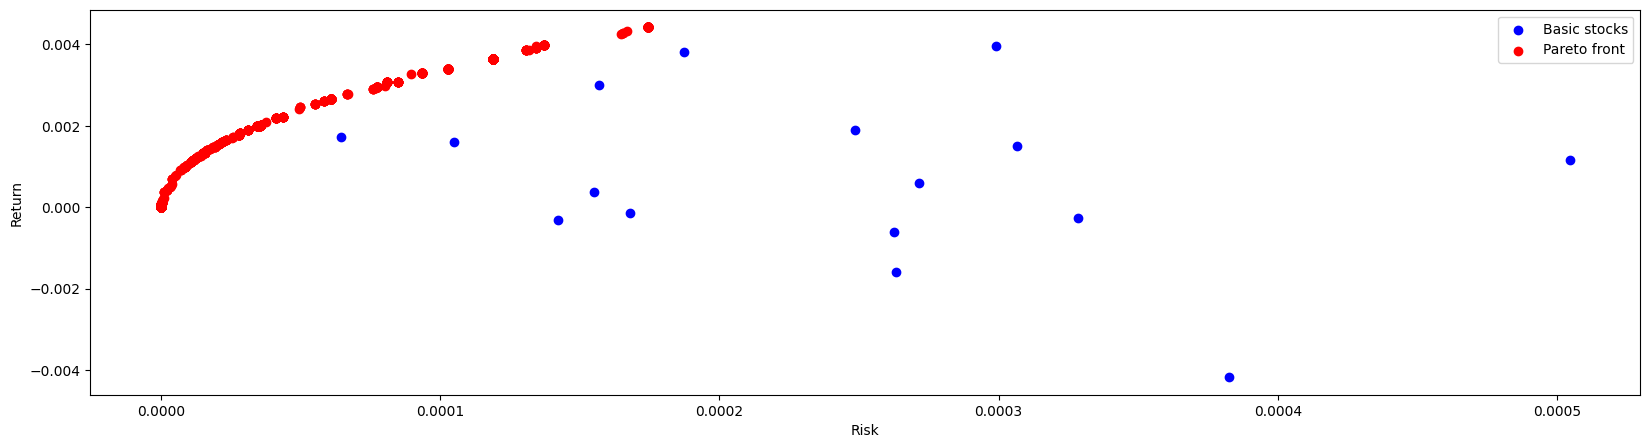

In [13]:
show_results(number_of_iterations=1000)